In [52]:
import numpy as np
from skimage import io, color, transform
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import os
image_size = 256
# image = np.random.rand(image_size, image_size, 3)
# image[:, :, 0] = image[:, :, 0] * 100
# image[:, :, 1:] = image[:, :, 1:] * 256 - 128

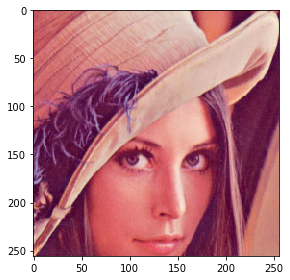

In [35]:
images = np.zeros((5, image_size, image_size, 3))
for index, image in enumerate(os.listdir("test")):
    images[index, :, :, :] = transform.resize(io.imread("test/" + image), (image_size, image_size))

io.imshow(images[2])
plt.show()
images = color.rgb2lab(images)

[[ 43.85344417  17.75441396]
 [ 43.89682976  17.82585853]
 [ 44.11139218  18.19755662]
 ..., 
 [ 23.60078995  16.59686869]
 [ 23.63600594  16.62756938]
 [ 23.63600594  16.62756938]]


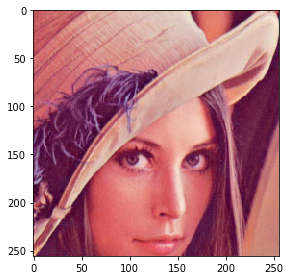

In [46]:
print images[2, :, :, 1:].reshape(256*256, 2)
io.imshow(color.lab2rgb(images[2].flatten().reshape(image_size, image_size, 3)))
plt.show()

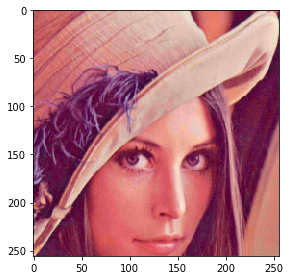

In [66]:
buckets = np.load("pts_in_hull.npy")
def bucketize(image, buckets):
    image = image[:, :, 1:]
    distances = cdist(image.reshape(image_size*image_size, 2), buckets)
    closest = np.argmin(distances, axis=1)
    return closest.reshape(image_size, image_size)
bucketized = bucketize(images[2], buckets)
reverted = np.zeros((image_size, image_size, 3))
reverted[:, :, 0] = images[2, :, :, 0]
reverted[:, :, 1:] = buckets[bucketized]
io.imshow(color.lab2rgb(reverted))
plt.show()

In [ ]:
# colors = np.arange(-135, 145, 10)
# bins_to_colors = np.arange(-130, 140, 10)
# bins_to_colors[0] = -128
# bins_to_colors[-1] = 127
# print(bins_to_colors)
# bins = np.zeros((5, image_size, image_size))
# binned = np.zeros((5, image_size, image_size, 676))
# # image_colors_positived = images[:, :, :, 1:] + 133
# image_colors_in_bins = np.digitize(images[:, :, :, 1:], colors)
# image_colors_in_bins = image_colors_in_bins - 1
# one_hot = np.eye(676)
# bins = 26*image_colors_in_bins[:, :, :, 0] + image_colors_in_bins[:, :, :, 1]
# binned[:, :, :] = one_hot[bins[:, :, :]]
# print np.argwhere(binned[1]==1)[:, 2].reshape((image_size, image_size))

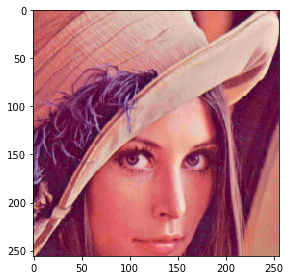

In [56]:
# reverted_image = np.zeros((image_size, image_size, 3)).astype(int)
# image_binned = np.argwhere(binned[2, :, :]==1)[:, 2].reshape((image_size, image_size))
# reverted_image[:, :, 0] = images[2, :, :, 0]
# reverted_image[:, :, 2] = np.mod(image_binned ,np.full((image_size, image_size), 26))
# reverted_image[:, :, 1] = (image_binned - reverted_image[:, :, 2]) / 26


# reverted_image[:, :, 1:] = bins_to_colors[reverted_image[:, :, 1:]]
# reverted_image = reverted_image*1.0
# io.imshow(color.lab2rgb(reverted_image))

# plt.show()

In [50]:
x = np.zeros((1, 1, 3))
x[0, 0, 0] = 50
x[0, 0, 1] = 124
x[0, 0, 2] = 125
color.lab2rgb(x)

array([[[ 1.,  0.,  0.]]])